In [5]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve
)

# Handling imbalance (we may use it later)
from imblearn.over_sampling import SMOTE

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [6]:
df = pd.read_csv("/content/Fraud.csv")

In [7]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42271 entries, 0 to 42270
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            42271 non-null  int64  
 1   type            42271 non-null  object 
 2   amount          42271 non-null  float64
 3   nameOrig        42271 non-null  object 
 4   oldbalanceOrg   42271 non-null  float64
 5   newbalanceOrig  42271 non-null  float64
 6   nameDest        42271 non-null  object 
 7   oldbalanceDest  42270 non-null  float64
 8   newbalanceDest  42270 non-null  float64
 9   isFraud         42270 non-null  float64
 10  isFlaggedFraud  42270 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.5+ MB


In [9]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  42271.000000  4.227100e+04   4.227100e+04    4.227100e+04   
mean       7.171087  1.490108e+05   7.727734e+05    7.874065e+05   
std        2.118037  3.145005e+05   2.284003e+06    2.321941e+06   
min        1.000000  1.770000e+00   0.000000e+00    0.000000e+00   
25%        7.000000  7.031875e+03   0.000000e+00    0.000000e+00   
50%        8.000000  2.751283e+04   1.856733e+04    3.339900e+02   
75%        8.000000  1.794321e+05   1.421965e+05    1.500335e+05   
max        9.000000  1.000000e+07   2.854724e+07    2.861740e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    4.227000e+04    4.227000e+04  42270.000000         42270.0  
mean     8.450982e+05    1.158405e+06      0.002224             0.0  
std      2.466743e+06    2.960508e+06      0.047105             0.0  
min      0.000000e+00    0.000000e+00      0.000000             0.0  
25%      0.000000e+00    0.000000e+00      0.000000             0.0  
50%      0.000000e+00    0.000000e+00      0.000000             0.0  
75%      4.337969e+05    8.013660e+05      0.000000             0.0  
max      2.958454e+07    3.130692e+07      1.000000             0.0

**DATA CLEANING **


In [10]:
# Drop columns that are not useful
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# One-hot encode the 'type' column
df = pd.get_dummies(df, columns=['type'])

# Create new features to improve model understanding
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Preview the cleaned data
df.head()


step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_IN  type_CASH_OUT  \
0             0.0      0.0             0.0         False          False   
1             0.0      0.0             0.0         False          False   
2             0.0      1.0             0.0         False          False   
3             0.0      1.0             0.0         False           True   
4             0.0      0.0             0.0         False          False   

   type_DEBIT  type_PAYMENT  type_TRANSFER  errorBalanceOrig  errorBalanceDest  
0       False          True          False               0.0           9839.64  
1       False          True          False               0.0           1864.28  
2       False         False           True               0.0            181.00  
3       False         False          False               0.0          21363.00  
4       False          True          False               0.0          11668.14

In [11]:
# Check for missing values
print(df.isnull().sum())

# Count how many fraud and non-fraud transactions
print(df['isFraud'].value_counts())


step                0
amount              0
oldbalanceOrg       0
newbalanceOrig      0
oldbalanceDest      1
newbalanceDest      1
isFraud             1
isFlaggedFraud      1
type_CASH_IN        0
type_CASH_OUT       0
type_DEBIT          0
type_PAYMENT        0
type_TRANSFER       0
errorBalanceOrig    0
errorBalanceDest    1
dtype: int64
isFraud
0.0    42176
1.0       94
Name: count, dtype: int64


In [12]:
df.dropna(inplace=True)


 Exploratory Data Analysis (EDA)

<Axes: xlabel='isFraud', ylabel='count'>

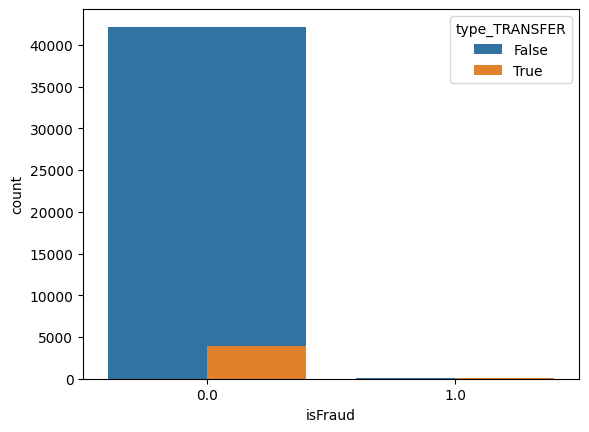

In [13]:

# 1. Fraud vs Non-Fraud Counts
sns.countplot(x='isFraud', data=df)

# 2. Transaction types by fraud
sns.countplot(x='isFraud', hue='type_TRANSFER', data=df)

<Axes: >

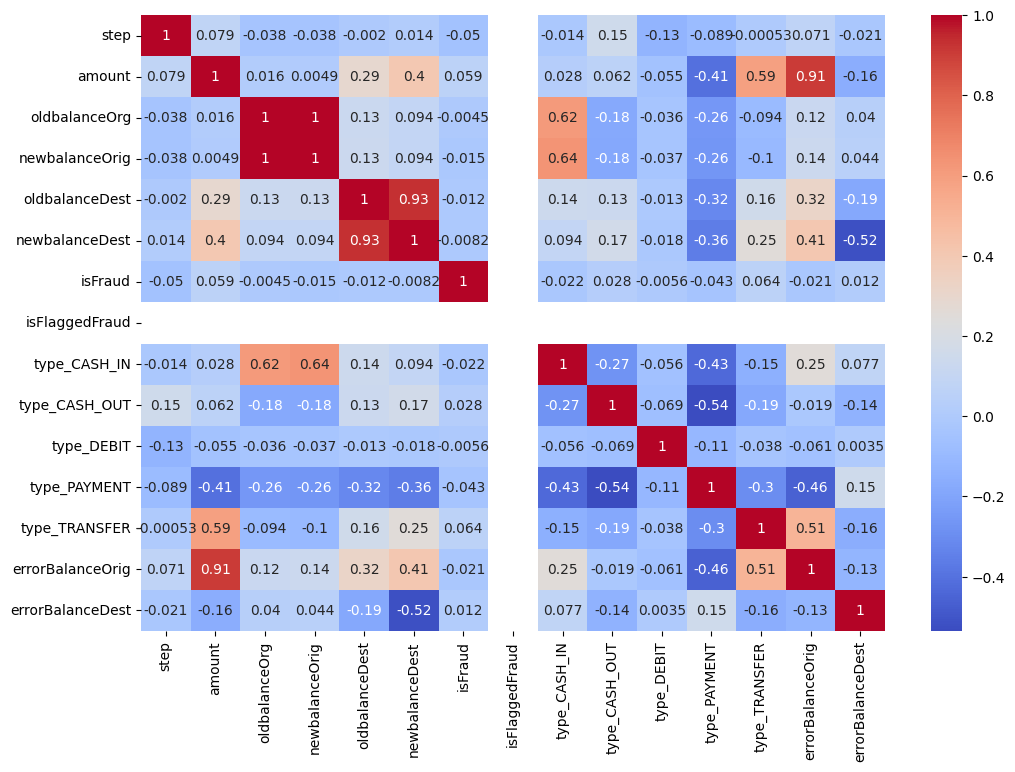

In [14]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


Feature Selection + Train-Test Split

In [15]:
# Drop the target leakage or unnecessary columns if any (optional)
# df.drop(['step'], axis=1, inplace=True)  # Keep if you want time info

# Define Features (X) and Target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (29589, 14)
Test shape: (12681, 14)


Model Building (Random Forest Classifier)

In [16]:
# Step 5: Train a Random Forest Model (Simple way for beginners)

# Creating the model
# n_estimators means number of trees
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model on the training data
model.fit(X_train, y_train)

# Predicting on the test data
y_pred = model.predict(X_test)

# Checking how well the model performed
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[12653     0]
 [    2    26]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12653
         1.0       1.00      0.93      0.96        28

    accuracy                           1.00     12681
   macro avg       1.00      0.96      0.98     12681
weighted avg       1.00      1.00      1.00     12681

Accuracy: 0.9998422837315669


Handle Class Imbalance

In [17]:
# Step 6: Handling Imbalanced Dataset using SMOTE

# Creating SMOTE object
sm = SMOTE(random_state=42)

# Applying SMOTE only on training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Printing new shape after applying SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: isFraud
0.0    29523
1.0       66
Name: count, dtype: int64
After SMOTE: isFraud
0.0    29523
1.0    29523
Name: count, dtype: int64


 Retrain the Model on Balanced Data

In [18]:
# Re-training the model on SMOTE-balanced data

# Creating a new RandomForest model
model_balanced = RandomForestClassifier(n_estimators=100, random_state=42)

# Training on resampled data
model_balanced.fit(X_train_res, y_train_res)

# Predicting again
y_pred_bal = model_balanced.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bal))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_bal))

print("Accuracy:", accuracy_score(y_test, y_pred_bal))


Confusion Matrix:
[[12647     6]
 [    3    25]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12653
         1.0       0.81      0.89      0.85        28

    accuracy                           1.00     12681
   macro avg       0.90      0.95      0.92     12681
weighted avg       1.00      1.00      1.00     12681

Accuracy: 0.9992902767920511


1. How did you clean the data?
->I dropped irrelevant columns like nameOrig and nameDest. Then I used get_dummies for categorical variables like type, handled missing values, and created new features like errorBalanceOrig and errorBalanceDest to capture inconsistencies in balances.

2. Describe your fraud detection model.
->I used a Random Forest Classifier, which is good for tabular data and works well with imbalanced classes. I trained it using balanced data (SMOTE) and evaluated its performance using accuracy, recall, and precision.

3. How did you select variables?
->I kept all meaningful numeric features, one-hot encoded transaction types, and added two new features (errorBalanceOrig, errorBalanceDest). I removed names to prevent overfitting and checked feature correlation to avoid multicollinearity.

4. How did you evaluate model performance?
->I used accuracy, precision, recall, F1-score, and confusion matrix. Since the fraud class is rare, I focused on recall and precision for fraud cases.

5. What are the key indicators of fraud?
->Most frauds happen in TRANSFER and CASH_OUT types. Also, many frauds have a balance inconsistency (errorBalanceOrig ≠ 0), meaning the full balance was removed in one transaction.

6. Do these factors make sense?
->Yes. Fraudsters often transfer or cash out full balances. So, detecting sudden full withdrawals and transfer patterns is logical and helps identify fraud.

7. What prevention can be adopted?
->The company should:

Set alerts for large transfers

Flag accounts with 100% balance withdrawal

Monitor sudden activity spikes

Use AI models like this one in real-time

8. How to check if the new system works?
->We can compare fraud count before and after implementation. Also, track:

Reduction in fraud losses

Alerts triggered vs. actual frauds

Feedback from flagged users